# Construct surface elevation time series along the centerline

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import rioxarray as rxr
import xarray as xr
import numpy as np
from matplotlib.cm import ScalarMappable
import geopandas as gpd
from shapely.geometry import LineString, Point
import pandas as pd
from tqdm import tqdm

## Define paths to data files

In [2]:
# Path to "data" in local directory, meant to mimic the shared Google Drive "data" folder
data_path = "/Volumes/LaCie/raineyaberle/Research/Hubbard/data" 

# Bed topography
bed_file = os.path.join(data_path, "bed_topo", 'Hubbard_IfSAR_Bathy_Millan_Icebridge.tiff')

# Centerline
center_file = os.path.join(data_path, 'flowline_5.csv')

# DEMs
ifsar_fn = os.path.join(data_path, 'DEMs', 'ifsar_hubbardDEM.tif')
arcticdem_files = sorted(glob.glob(os.path.join(data_path, "DEMs", "mosaics", "*.tif")))
print(f"Located {len(arcticdem_files)} DEM mosaics.")

# Outputs
out_crs = "EPSG:3338" # Alaska Albers
figures_out_path = os.path.join(data_path, "..", "Figures") # where figures will be saved
h_out_path = os.path.join(data_path, "DEMs") # where centerline elevations will be saved

Located 99 DEM mosaics.


## Load and resample the centerline

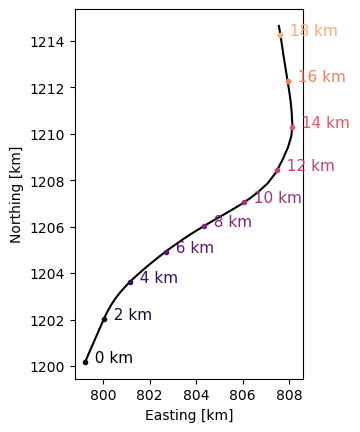

In [3]:
def create_distance_vector(line):
    x, y = line.coords.xy[0], line.coords.xy[1]
    line_dist = np.zeros(len(line.coords.xy[0]))
    for i in range(1, len(line.coords.xy[0])):
        line_dist[i] = np.sqrt((x[i]-x[i-1])**2 + (y[i]-y[i-1])**2) + line_dist[i-1]
    return line_dist

def resample_linestring(line, distance=2):
    # create initial distance vector
    line_dist = create_distance_vector(line)
    
    # create new line distance vector
    new_line_dist = np.arange(0, np.nanmax(line_dist), step=distance)

    # grab x and y coordinates
    x, y = line.coords.xy

    # interpolate coordinates on new distance vector
    new_x = np.interp(new_line_dist, line_dist, x)
    new_y = np.interp(new_line_dist, line_dist, y)

    # save as linestring
    new_coords = list(zip(new_x, new_y))
    new_line = LineString(new_coords)
    
    return new_line, new_line_dist

# --- Load centerline ---
center_df = pd.read_csv(center_file)
# FLIP to start at the terminus
center_df = center_df[::-1].reset_index(drop=True)
# convert to geopandas.GeoDataFrame with CRS
center_df["geometry"] = [Point(xy) for xy in list(zip(center_df[["x", "y"]].values))]
center_gdf = gpd.GeoDataFrame(center_df, geometry="geometry", crs="EPSG:3413")
# reproject to Alaska Albers
center_gdf = center_gdf.to_crs("EPSG:3338")
# extract line
center = LineString(center_gdf["geometry"].values)

# --- Resample ---
center_resamp, center_dist = resample_linestring(center)

# --- Plot ---
fig, ax = plt.subplots()

x_resamp, y_resamp = center_resamp.coords.xy
ax.plot(np.array(x_resamp)/1e3, np.array(y_resamp)/1e3, '-k')
# plot distance labels
dist_vector = np.arange(0, np.max(center_dist), step=2e3)
x_km = np.interp(dist_vector, center_dist, x_resamp)
y_km = np.interp(dist_vector, center_dist, y_resamp)
colors = plt.cm.magma(np.linspace(0, 1, len(dist_vector)+2))
for i, (x, y, d) in enumerate(zip(x_km, y_km, dist_vector)):
    ax.plot(x/1e3, y/1e3, '.', color=colors[i])
    ax.text(
        x/1e3, y/1e3,
        f"  {int(d/1e3)} km",
        color=colors[i],
        fontsize=11
    )

ax.set_aspect('equal')
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
plt.show()



In [4]:
# --- Sample surface elevations from DEMs ---
# Check if sampled elevations already exist in file
h_center_file = os.path.join(h_out_path, 'centerline_surface_elevation_timeseries.csv')
if os.path.exists(h_center_file):
    h_center_df = pd.read_csv(h_center_file)
    h_center = h_center_df.iloc[:,2:].values
    print('Centerline surface profiles loaded from file.')

else:

    def sample_dem(dem_file, out_crs, center_x, center_y):
        dem = rxr.open_rasterio(dem_file).squeeze()
        dem = dem.rio.reproject(out_crs)
        dem = xr.where(dem==dem.attrs["_FillValue"], np.nan, dem)

        date = os.path.basename(dem_file)[0:8]
        dataset = os.path.basename(dem_file).split("_")[1]

        h_center = np.array([float(dem.sel(x=x, y=y, method='nearest').data) for x,y in zip(center_x, center_y)])
        # remove wacky values
        h_center[np.abs(h_center) > 1500] = np.nan

        h_center_df = pd.DataFrame({
            "Date": [date],
            "Dataset": [dataset]
        }, index=[0])
        for i in range(len(h_center)):
            h_center_df = pd.concat([
                h_center_df, 
                pd.DataFrame({center_dist[i]: [h_center[i]]}, index=[0])
                ], axis=1)

        return h_center_df

    # Grab centerline x and y coordinates for convenience
    center_x, center_y = center_resamp.coords.xy

    # Iterate over DEMs
    h_center_list = []
    for dem_file in tqdm(arcticdem_files):
        h_center_list += [sample_dem(
            dem_file, out_crs, center_x, center_y
        )]

    h_center_df = pd.concat(h_center_list, ignore_index=True, axis=0)
    h_center_df = h_center_df.sort_values(by="Date").reset_index(drop=True)
    
    h_center_df.to_csv(h_center_file, index=False)
    print('Centerline surface elevations saved to file:', h_center_file)

    # switch to numpy array for convenience
    h_center = h_center_df.iloc[:,2:].values

h_center_df


Centerline surface profiles loaded from file.


,Date,Dataset,0.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,...,18380.0,18382.0,18384.0,18386.0,18388.0,18390.0,18392.0,18394.0,18396.0,18398.0
0,20130522,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,771.429688,771.578125,771.640625,771.765625,771.953125,772.09375,772.234375,772.375,772.515625,772.648438
1,20130526,ArcticDEM,126.148438,128.515625,130.65625,137.085938,138.242188,139.640625,140.539062,142.382812,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20130611,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20130616,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20130624,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,20230516,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,20230604,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,20230618,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,20230620,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Smooth the elevation profiles

In [5]:
# --- Check if smoothed surface profiles already exist in directory ---
h_center_smooth_fn = os.path.join(h_out_path, 'centerline_surface_elevation_timeseries_smooth.csv')
if os.path.exists(h_center_smooth_fn):
    h_center_smooth_df = pd.read_csv(h_center_smooth_fn)
    h_center_smooth = h_center_smooth_df.iloc[:,2:].values
    print('Smoothed surface profiles loaded from file.')

else:

    # Smooth each elevation profile
    def moving_average_smoothing(arr, window_size=100):
        smoothed_arr = np.zeros_like(arr)
        for i in range(arr.shape[0]):
            smoothed_arr[i, :] = np.convolve(arr[i, :], np.ones(window_size) / window_size, mode='same')
            # set non-valid points to NaN
            smoothed_arr[i,0:int(window_size/4)] = np.nan
            smoothed_arr[i,-int(window_size/4):] = np.nan
        return smoothed_arr
    h_center_smooth = moving_average_smoothing(h_center)
    
    # Reformat as DataFrame and save to file
    h_center_smooth_df = h_center_df.copy()
    h_center_smooth_df.iloc[:, 2:] = h_center_smooth
    
    # Save to file
    h_center_smooth_df.to_csv(h_center_smooth_fn, index=False)
    print('Smoothed centerline surface elevations saved to file:', h_center_smooth_fn)

h_center_smooth_df



Smoothed surface profiles loaded from file.


,Date,Dataset,0.0,2.0,4.0,6.0,8.0,10.0,12.0,14.0,...,18380.0,18382.0,18384.0,18386.0,18388.0,18390.0,18392.0,18394.0,18396.0,18398.0
0,20130522,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20130526,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20130611,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20130616,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20130624,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,20230516,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,20230604,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,20230618,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,20230620,ArcticDEM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Plot

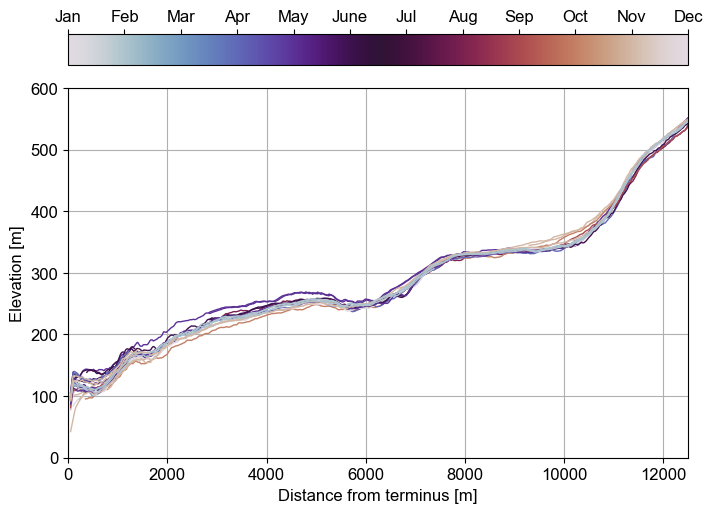

In [6]:
# Set up figure
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1, 1, figsize=(8,6))
lw=1

# Define colormap for surface profiles
cmap = plt.cm.twilight

h_center_smooth_df["month"] = [pd.Timestamp(f"{x[0:4]}-{x[4:6]}-{x[6:8]}").month for x in h_center_smooth_df["Date"].values.astype(str)]
for i,row in h_center_smooth_df.iterrows():
    color = cmap((row["month"]-1)/11)
    ax.plot(center_dist, h_center_smooth[i,:], '-', linewidth=lw, color=color)

# Plot the colorbar
sm = ScalarMappable(cmap=cmap)
cbar = fig.colorbar(sm, ax=ax, location='top')
cbar.ax.set_xticks(np.linspace(0,1,num=12))
cbar.ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Adjust axes
ax.set_xlim(0, 12.5e3)
ax.set_ylim(0, 600)
ax.grid()
ax.set_xlabel('Distance from terminus [m]')
ax.set_ylabel('Elevation [m]')

plt.show()